In [290]:
#!c1.8
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [291]:
#!c1.8
from pathlib import Path  
import numpy as np  
import torch 
from torch.utils.data import Dataset, DataLoader 
from torch.utils.data.dataset import Subset 
from torchvision.datasets import ImageFolder 
from torchvision.transforms import Compose, RandomResizedCrop, RandomVerticalFlip, RandomHorizontalFlip 
from torchvision.transforms import ColorJitter, ToTensor, Normalize  
import torch.nn as nn 

In [293]:
#!c1.8
import splitfolders

input_folder = 'Images/'
splitfolders.ratio(input_folder, 'images_splited', ratio = (0.65, 0.2, 0.15), seed=13, group_prefix=None)


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  2.40 files/s]
Copying files: 42 files [00:00,  3.43 files/s]
Copying files: 84 files [00:00,  4.88 files/s]
Copying files: 118 files [00:00,  6.92 files/s]
Copying files: 153 files [00:00,  9.81 files/s]
Copying files: 181 files [00:00, 13.77 files/s]
Copying files: 208 files [00:01, 19.21 files/s]
Copying files: 234 files [00:01, 26.49 files/s]
Copying files: 260 files [00:01, 34.64 files/s]
Copying files: 299 files [00:01, 47.63 files/s]
Copying files: 340 files [00:01, 64.80 files/s]
Copying files: 380 files [00:01, 86.54 files/s]
Copying files: 421 files [00:01, 113.36 files/s]
Copying files: 461 files [00:01, 144.37 files/s]
Copying files: 504 files [00:01, 180.06 files/s]
Copying files: 543 files [00:02, 199.73 files/s]
Copying files: 579 files [00:02, 229.86 files/s]
Copying files: 615 files [00:02, 257.63 files/s]
Copying files: 654 files [00:02, 286.39 files/s]
Copying files: 691 files [00:02, 299.22 fi

In [294]:
#!c1.8
!ls 'images_splited/train'

Inter	    Nunito    Oswald  Raleway  SourceSansPro
Montserrat  OpenSans  PTSans  Roboto   Ubuntu


In [297]:
#!c1.8
import torchvision
from torchvision import transforms, models

train_dir = 'images_splited/train'
val_dir = 'images_splited/val'
test_dir = 'images_splited/test'

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, image_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, image_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, image_transforms)

In [298]:
#!c1.8
print(train_dataset.class_to_idx)

{'Inter': 0, 'Montserrat': 1, 'Nunito': 2, 'OpenSans': 3, 'Oswald': 4, 'PTSans': 5, 'Raleway': 6, 'Roboto': 7, 'SourceSansPro': 8, 'Ubuntu': 9}


In [299]:
#!c1.8
import torch
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

In [307]:
#!c1.8
import matplotlib.pyplot as plt
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    plt.imshow(image.clip(0, 1), cmap = 'gray')
    plt.title(title)
    plt.show()
    plt.pause(0.001)

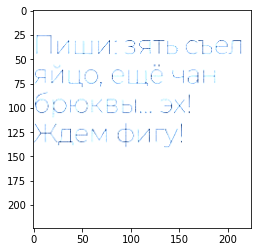

In [308]:
#!c1.8
X_batch, y_batch = next(iter(train_dataloader))
show_input(X_batch[0])

In [309]:
#!c1.8
from tqdm import tqdm

def train_model(model, loss, optimizer, scheduler, num_epochs):
    test_accuracy_history = []
    test_loss_history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                print(labels)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            test_loss_history.append(epoch_loss)
            test_accuracy_history.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model, test_loss_history, test_accuracy_history

In [310]:
#!c1.8
model = models.resnet18(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, 10)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [311]:
#!c1.8
model_ft, test_loss_history, test_accuracy_history = train_model(model, loss, optimizer, scheduler, num_epochs=10)

2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3])
ten

100%|██████████| 497/497 [00:54<00:00,  9.14it/s]


In [313]:
#!c1.8
torch.save(model_ft.state_dict(), "models/res_net")

In [314]:
#!c1.8
# Specify a path
PATH = "models/resnet_model.pt"

# Save
torch.save(model_ft, PATH)

# Load
model_res = torch.load(PATH)
model_res.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

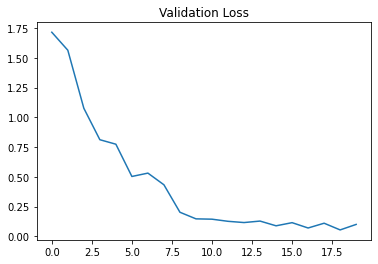

In [315]:
#!c1.8
import matplotlib.pyplot as plt
plt.plot(test_loss_history)
plt.title('Validation Loss');

Text(0.5, 1.0, 'Validation Accuracy')

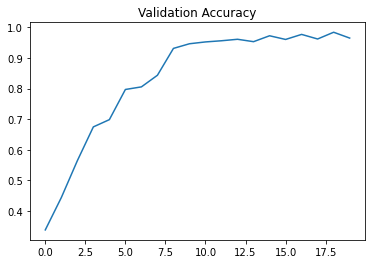

In [316]:
#!c1.8
plt.plot(test_accuracy_history)
plt.title('Validation Accuracy')

In [ ]:
#!c1.8
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

from PIL import Image
img_mont = Image.open("../models_rgb/Images/Montserrat/Montserrat-Black0.jpg").convert('RGB')

img_mont_preprocessed = preprocess(img_mont)

batch_img_mont_tensor = torch.unsqueeze(img_mont_preprocessed, 0)

In [ ]:
#!c1.8
out = model_res(batch_img_mont_tensor)

In [288]:
#!c1.8
out

tensor([[  4.1616,   5.0535,  -7.6136,  -2.7699, -19.2047, -11.7889,   3.4237,
           3.0470,  -3.5595,   3.4123]], grad_fn=<AddmmBackward>)

In [289]:
#!c1.8
print(train_dataset.class_to_idx)

{'Inter': 0, 'Montserrat': 1, 'Nunito': 2, 'OpenSans': 3, 'Oswald': 4, 'PTSans': 5, 'Raleway': 6, 'Roboto': 7, 'SourceSansPro': 8, 'Ubuntu': 9}


In [317]:
#!c1.8
import torch
PATH = "models/resnet_model.pt"

# Load
model_res = torch.load(PATH)

In [318]:
#!c1.8
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
sm = nn.Softmax(dim = 1)
batch_size = 8
model = model_res
dataloader = val_dataloader
def test(model,dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.FloatTensor)
        target = target.type(torch.LongTensor)
        model.eval()
        output = model(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.numpy()
        target = target.numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [319]:
#!c1.8
from torch.autograd import Variable
true,pred,image,true_wrong,pred_wrong = test(model, dataloader)

tensor(0.9645, dtype=torch.float64) 0.0994211786487038


In [320]:
#!c1.8
from sklearn import metrics
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [321]:
#!c1.8
performance_matrix(true,pred)

Confusion Matrix:
 [[383   1   0   1   0   0   7   8   0   0]
 [  0 381   0   0   0   0  10   4   0   1]
 [  0   0 378   4   0   2   0   0   0   0]
 [  1   1   0 376   0   7   1   0   2   4]
 [  1   0   0   0 405   0   0   0   0   0]
 [  0   0   1   4   0 398   0   0   4   1]
 [  5  11   0   0   0   0 379   3   0   2]
 [  8   0   1   0   0   0   5 360   1   9]
 [  0   0   0   6   0   4   1   1 372   0]
 [  4   1   0   1   0   0   0   7   0 403]]
Precision: 96.6103220902627 Recall: 96.58707027481839, Accuracy: 96.59949622166248: ,f1_score: 96.59741735264105


In [ ]:
#!c1.8
